# Introduction to Neuroinformatics
## Exercise session 5: Models of the visual system

Welcome to the fifth exercise session of the introduction to neuroinformatics course. This exercise session is more exploratory and will walk you through various methods for exploring information processing in convolutional neural networks. During the lecture we studied how the responses of single neurons can inform us about the way the visual system works. In this exercise session, we will apply a similar approach to models of the visual system, to try to answer the question: <b>What is a good model of the brain's visual system?</b>

# Table of contents:

* [Packages](#packages)
* [1: Convolution neural networks as a model of the visual system](#cnns)
    * [1.1: Receptive Fields of CNNs](#rfs_cnns)
    * [1.2: Stimuli: Sinusoidal gratings](#gratings)
    * [1.3: Presenting stimuli to CNNs](#stimuli_cnns)
    * [1.4: Contrast saturation](#contrast_cnns)
    * [1.5: Cross-orientation inhibition](#inhibtion_cnns)
    

* [2: Rao and Ballard model of predictive coding in V1](#rao_ballard)
    * [2.1: Contrast saturation](#contrast_rao)
    * [2.2: Cross-orientation inhibition](#inhibtion_rao)


# Packages <a class="anchor" id="packages"></a>
This notebook was <font color='red'>**designed to be run in colab**</font>. We have included code blocks to allow the possibility of running the notebook locally, but due to the vastness of peoples' setups, we do not support it much further.

If you wish to continue in Colab, click on the "Copy to Drive" button to be able to save your progress.

The following cells are used to install the necessary packages and libraries for the exercise:

In [108]:
!which python  # This displays which python is being used
!pwd # This displays the current directory

/usr/local/bin/python
/content


In [109]:
!pip install --quiet scipy PyQt6 ipywidgets wget ipympl # Install necessary packages

In [110]:
import os
import wget
# Define the URL and the output directory
output_dir = 'utils_ex5'
url_1 = f'https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/{output_dir}/vgg_utils.py'
url_2 = f'https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/{output_dir}/rao_ballard_trained.pkl'
if not os.path.exists(output_dir):
    # Create the directory if it doesn't already exist
    os.makedirs(output_dir, exist_ok=True)

    # Download the file into the specified directory
    print(f"Downloading files to '{output_dir}'...")

    filename_1 = wget.download(url_1, out=output_dir)
    print(f"\nFile successfully downloaded as: {filename_1}")

    filename_2 = wget.download(url_1, out=output_dir)
    print(f"\nFile successfully downloaded as: {filename_2}")


!wget -P utils_ex5/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex5/vgg_utils.py
!wget -P utils_ex5/ https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex5/rao_ballard_trained.pkl


--2025-10-15 21:49:41--  https://github.com/ManteLab/Iton_notebooks_public/raw/refs/heads/main/utils_ex5/vgg_utils.py
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex5/vgg_utils.py [following]
--2025-10-15 21:49:41--  https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/utils_ex5/vgg_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15615 (15K) [text/plain]
Saving to: ‘utils_ex5/vgg_utils.py.3’

vgg_utils.py.3      100%[===================>]  15.25K  --.-KB/s    in 0.003s  

2025-10-15 21:49:41 (4.68 MB/s

In [111]:
# Import packages
import torch # Machine learning package

import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, FloatSlider
import ipywidgets as widgets


from utils_ex5.vgg_utils import RaoBallard1999Model, create_bar_lengths, load_cnn_model, get_network_layers, create_grating, interactive_grating, create_contrast_gratings, create_orientation_gratings, plot_image_row, create_superimposed_gratings, load_rao_ballard, get_pref_and_orth_angle

---

## 1. Convolutional neural networks <a class="anchor" id="cnns"></a>

Convolutional neural networks (CNNs) are artificial neural network models that classify images by detecting what objects are inside the image. CNNs work by applying many "layers" of operations to the image to extract important information (below: feature learning). In a way, this is somewhat similar to the way the brain works by first computing simple properties of the world in primary visual cortex, and then building to complex representations in higher visual cortex. CNNs also work remarkably well as image classifiers, no other models come as close in accuracy to humans, so maybe they are a good model of the brain. In this exercise session we will try to find out.  



![](https://raw.githubusercontent.com/ManteLab/Iton_notebooks_public/refs/heads/main/images/cnn_architecture.png "Convolutional neural networks")

---
> **Assignment 1**
>
>Assuming that CNNs are a good model of the brain, what sort of "neurons" would we find in the first layers of the CNN?

Solution:


---



Now, let's load a convolutional neural network. (we are using a network called Alexnet, more info: [here](https://pytorch.org/hub/pytorch_vision_alexnet/))

In [112]:
convolutional_neural_net = load_cnn_model()
layers = get_network_layers(convolutional_neural_net)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


## 1.1: Receptive Fields of CNNs <a class="anchor" id="rfs_cnns"></a>

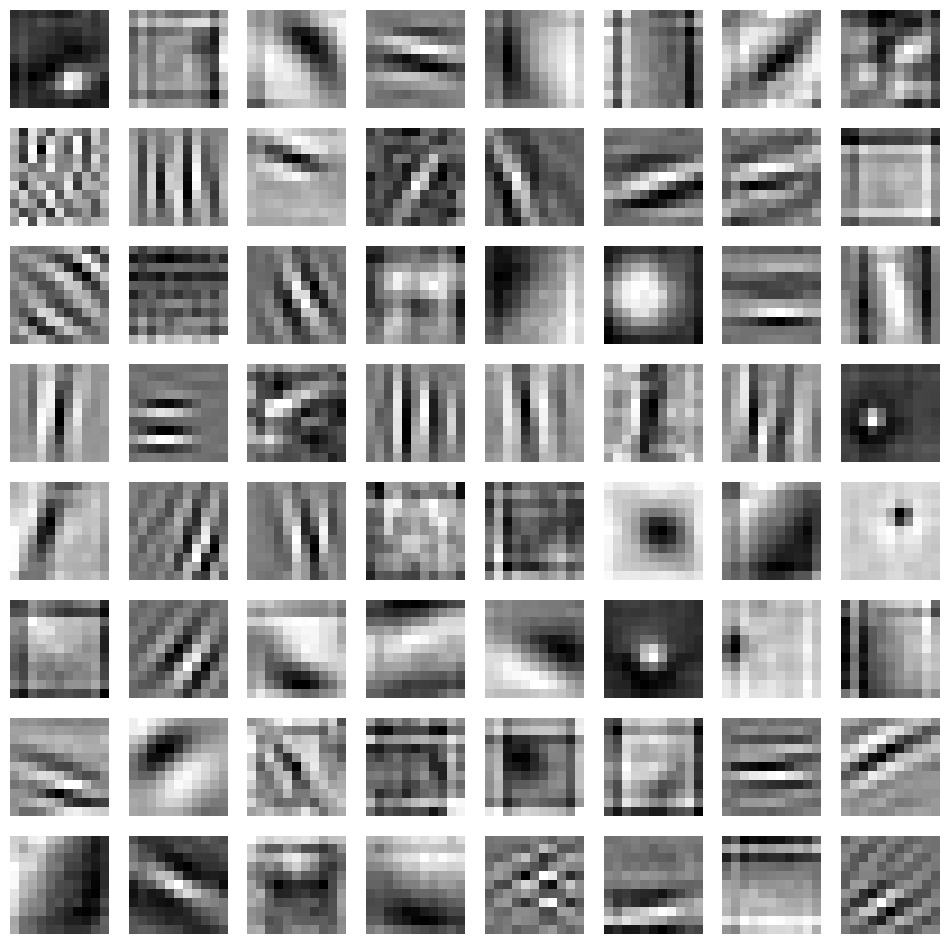

In [113]:

first_conv_layer = None
for layer in convolutional_neural_net.modules():
    if isinstance(layer, torch.nn.Conv2d):
        first_conv_layer = layer
        break

if first_conv_layer is not None:
    # Extract the weights
    filters = first_conv_layer.weight.data.clone()
    num_filters = filters.shape[0]

    # Determine the grid size for plotting
    grid_size = int(np.ceil(np.sqrt(num_filters)))

    # Plot the filters in a 2D grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 1.5, grid_size * 1.5))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(grid_size * grid_size):
        ax = axes[i]
        if i < num_filters:
            # Normalize the filter for visualization
            filter_image = filters[i].cpu().numpy()
            filter_image = (filter_image - filter_image.min()) / (filter_image.max() - filter_image.min())

            # Plotting the filter, assuming it's a 2D filter with a single channel
            ax.imshow(filter_image[2], cmap='gray')

        ax.axis('off')

    plt.show()
else:
    print("No convolutional layer found in the model.")


## 1.2: Stimuli: sinusoidal gratings <a class="anchor" id="gratings"></a>

In [114]:
# Create an interactive grating
interact(interactive_grating,
    frequency=FloatSlider(min=2, max=20, step=0.5, value=10, description="Frequency (Hz)"),
    radius=IntSlider(min=1, max=100, step=10, value=12, description="Radius"),
    contrast=FloatSlider(min=0.1, max=1., step=0.1, value=1, description="Contrast"),
    orientation=IntSlider(min=0, max=180, step=12, value=90, description="Orientation"),
    );

interactive(children=(FloatSlider(value=10.0, description='Frequency (Hz)', max=20.0, min=2.0, step=0.5), IntS…

---

> **Assignment 2**
>
> Assuming that CNNs are a good model of the brain, how would we expect the "neurons" in the first layers of the network to respond to the different parameters of the gratings? (Frequency, Radius, Contrast & Orientation)

Solution:



---
> **Assignment 3**
>
> How do you actually expect the CNNs to respond to these gratings?

Solution:



---

> **Assignment 4**
>
> Assuming that CNNs are a good model of the brain, what could we do to the gratings to elicit different responses in the final layers of the network?

Solution:


---

## 1.3: Presenting stimuli to CNNs <a class="anchor" id="stimuli_cnns"></a>

Just like the lecture, we will present different grating stimuli to the different "neurons" of the network. We will start with presenting gratings with different contrast levels.

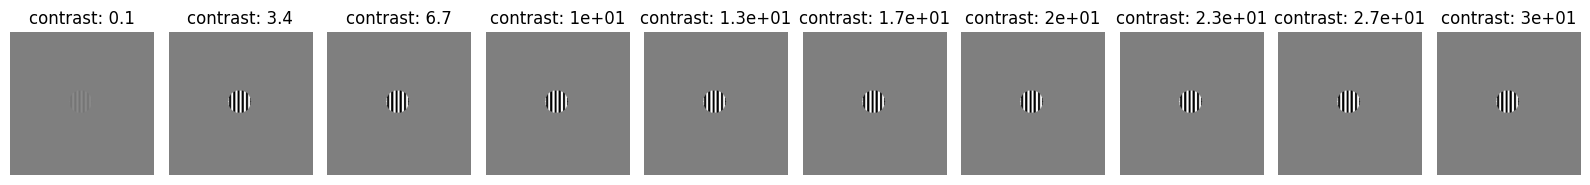

In [115]:
# Set parameters
size = (256, 256)
center_x = 125
center_y = 125
frequency = 7.5
orientation = 90
radius = 20


# Generate different gratings with increasing contrasts
contrasts = np.linspace(0.1, 30, 10)
gratings = create_contrast_gratings(frequency, radius, contrasts, orientation)
plot_image_row(gratings, titles=[f'contrast: {c:.2}' for c in contrasts])

Next, we will pass the gratings through the convolutional neural network, and plot the neural network responses.

We will investigate what types of computations are performed at the different layers. For this, we choose the number of layers we want to keep by setting the variable NUM_LAYERS and run a series of subsequent analyses to see how the output of the network looks like after NUM_LAYERS layers and how the output changes as we change the inputs.

We start with NUM_LAYERS = 1, which is the output of the (1): ReLU(inplace=True).

Run the following cell a few times, changing the parameter NUM_LAYERS, and look at
1) how the dimensionality of variable network_outputs changes, and
2) how the network's output, i.e. neuron_response, changes.

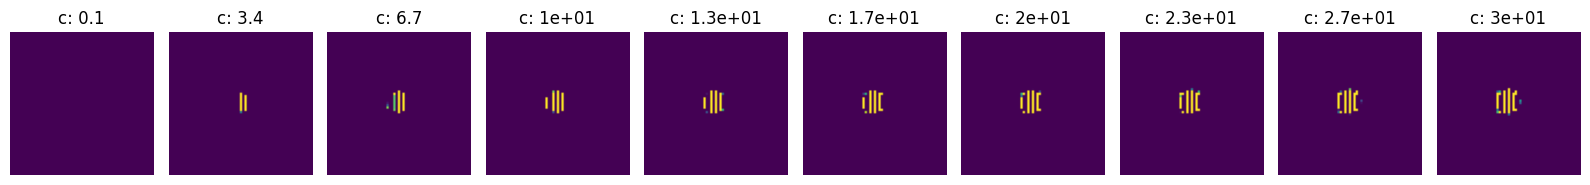

In [116]:
# Select the layers of the network we want to pass the gratings through
NUM_LAYERS = 1
network_layers = layers[0:NUM_LAYERS]

# Pass the gratings through the layers we selected
#this matrix has the following shape: contrasts x number of neurons x neuron response (2d)
network_outputs = network_layers(gratings).detach()


# Get the response from neuron 0
NEURON_NUMBER = 1
neuron_response = network_outputs[:, NEURON_NUMBER]

# Plot the responses of our neuron in the layer we selected
plot_image_row(neuron_response.unsqueeze(1), titles=[f'c: {c:.2}' for c in contrasts])

In [117]:
neuron_0_responses = network_outputs[:, 0]
print(neuron_0_responses.shape)

torch.Size([10, 63, 63])


## 1.4: Contrast saturation <a class="anchor" id="contrast_cnns"></a>


Now we will plot the activity of each neuron as a function of different stimuli contrasts. The orientation of the stimuli is fixed across the different contrasts. Each line illustrates one neuron.

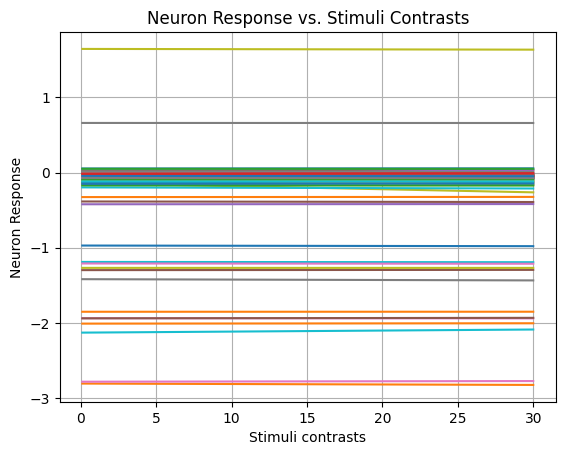

In [118]:
_=plt.plot(contrasts, network_outputs[:, :].detach().numpy().mean(-1).mean(-1))
# Set the x-axis and y-axis labels
plt.xlabel("Stimuli contrasts")
plt.ylabel("Neuron Response")

# Optionally set a title
plt.title("Neuron Response vs. Stimuli Contrasts")

# Show the plot
plt.grid()
plt.show()


## 1.5: Cross-orientation inhibition <a class="anchor" id="inhibtion_cnns"></a>


### Find preferred orientation for each neuron

The first step is to identify for each neuron its preferred orientation. We will do this by computing each neuron's response to gratings of different orientations. We consider the orientation that elicits the highest response the neuron's preferred orientation.

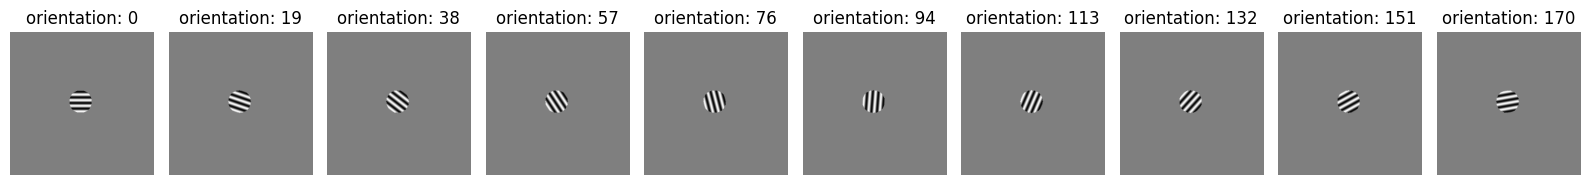

In [119]:

# Set parameters
size = 256
center = (125, 125)

radius = 20
frequency = 10
contrast = 2

orientations = np.linspace(0, 170, 10)

gratings = create_orientation_gratings(frequency, radius, contrast, orientations, size, center)
plot_image_row(gratings, titles=[f'orientation: {o:.0f}' for o in orientations])

Now we will plot the activity of each neuron as a function of different stimuli orientations. The contrast is now fixed. Each line illustrates one neuron.

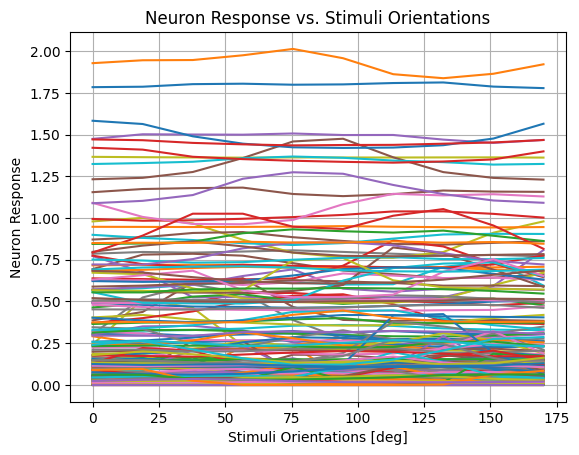

In [120]:
NUM_LAYERS = 5

network_layers = layers[0:NUM_LAYERS]
network_outputs = network_layers(gratings)


_=plt.plot(orientations, network_outputs[:, :].detach().numpy().mean(-1).mean(-1))
# Set the x-axis and y-axis labels
plt.xlabel("Stimuli Orientations [deg]")
plt.ylabel("Neuron Response")

# Optionally set a title
plt.title("Neuron Response vs. Stimuli Orientations")

# Show the plot
plt.grid()
plt.show()

We will determine each neuron's preferred orientation by looking which stimuli orientation elicited the highest response.

In [121]:
m = network_outputs[:, :].detach().numpy().mean(-1).mean(-1)
print(m.shape) # Number of Stimuli Orientations x Number of Neurons
max_indices = np.argmax(m, axis=0) # We take the maximum across rows, i.e. for each neuron we look which stimuli elicited the highest response
neuron_pref_orientation = orientations[max_indices]
print(neuron_pref_orientation.shape)

(10, 192)
(192,)


---

> **Assignment 5**
>
> Inspecting the figure above: are all neurons behaving similarly?

Solution:



---

> **Assignment 6**
>
>How could we select only the neurons that are tuned?

Solution:


---


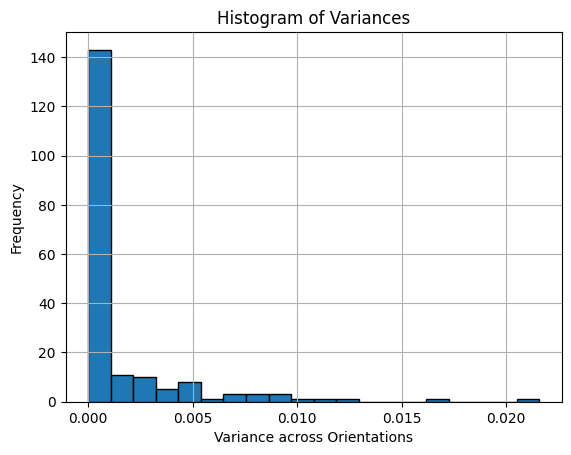

In [122]:
variances = np.var(m, axis=0)

# Plot the histogram of the variances
plt.hist(variances, bins=20, edgecolor='black')
plt.title("Histogram of Variances")
plt.xlabel("Variance across Orientations")
plt.ylabel("Frequency")
plt.grid()
plt.show()

### Super-imposing two gratings: grating of preferred orientation and grating of orthogonal orientation

For each neuron, we compute its response to its optimal grating superimposed with an orthogonal grating of varying contrasts.

In [123]:
valid_neurons = variances > 0.01 # We select an *arbitrary* threshold to focus only on the most tuned units
valid_neuron_indices = np.nonzero(valid_neurons)[0]

print("A list of tuned units: ", valid_neuron_indices)


A list of tuned units:  [  8  27  34 140]


Prefered orientation is 19 and orth orientation is 109


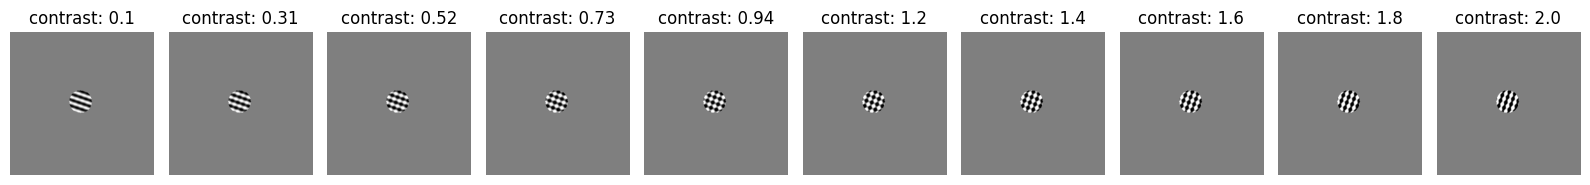

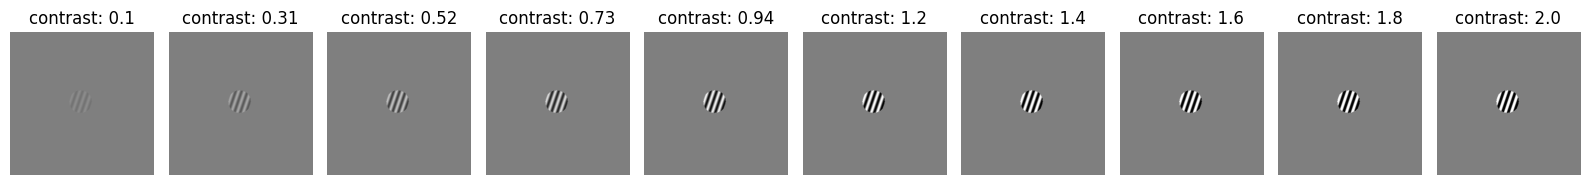

In [124]:
neuron_index = 0
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[neuron_index]])

print(f'Prefered orientation is {pref_orientation:.0f} and orth orientation is {orth_orientation:.0f}')

# Set parameters
size = 256
center = (125, 125)
radius = 20
frequency = 10
contrast = 2

orientations = np.linspace(0, 170, 10)
contrast_pref = np.linspace(1, 2, 1)
contrasts_orth = np.linspace(0.1, 2, 10)

gratings_superimposed = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size, center)
plot_image_row(gratings_superimposed, titles=[f'contrast: {c:.2}' for c in contrasts_orth])


gratings_orthogonal = create_contrast_gratings(frequency, radius, contrasts_orth, orth_orientation)
plot_image_row(gratings_orthogonal, titles=[f'contrast: {c:.2}' for c in contrasts_orth])





In [125]:
network_layers = layers[0:NUM_LAYERS]
network_outputs_superimposed = network_layers(gratings_superimposed)
network_outputs_orthogonal = network_layers(gratings_orthogonal)



### Response of a neuron to super-imposed gratings (one contrast value for preferred orientation grating)

The response of a neuron when we super-imposed a grating of orthogonal direction and varying contrasts to a grating of its preferred orientation and high contrast.

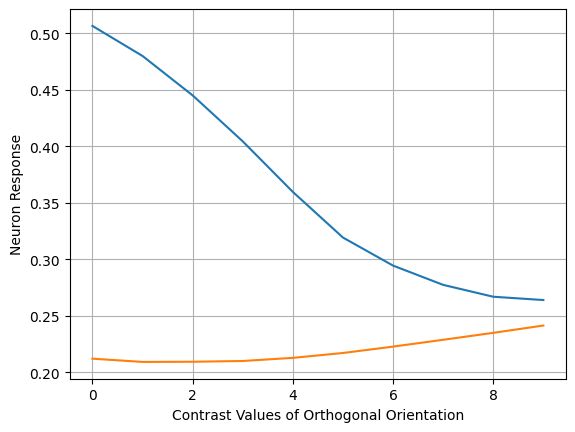

In [126]:
_=plt.plot(network_outputs_superimposed[:, valid_neuron_indices[neuron_index],:,:].detach().numpy().mean(-1).mean(-1))
_=plt.plot(network_outputs_orthogonal[:, valid_neuron_indices[neuron_index],:,:].detach().numpy().mean(-1).mean(-1))

plt.xlabel("Contrast Values of Orthogonal Orientation")
plt.ylabel("Neuron Response")

# Show the plot
plt.grid()
plt.show()

### Response of a neuron to super-imposed gratings (all contrast values for preferred orientation grating)

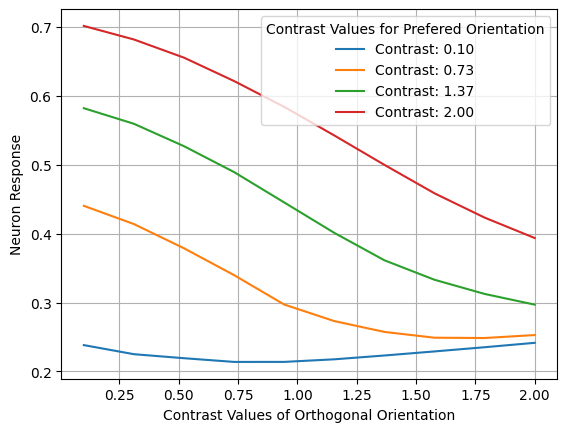

In [127]:
contrasts_orth = np.linspace(0.1, 2, 10)
contrasts_pref_sweep = np.linspace(0.1, 2, 4)

for c in contrasts_pref_sweep:
    contrast_pref = np.linspace(c, c, 1)
    gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size, center)

    network_layers = layers[0:NUM_LAYERS]
    network_outputs = network_layers(gratings)
    _=plt.plot(contrasts_orth, network_outputs[:, valid_neuron_indices[neuron_index],:,:].detach().numpy().mean(-1).mean(-1), label=f'Contrast: {c:.2f}')

plt.xlabel("Contrast Values of Orthogonal Orientation")
plt.ylabel("Neuron Response")

# Show the legend
plt.legend(title="Contrast Values for Prefered Orientation")
# Show the plot
plt.grid()
plt.show()

---

> **Assignment 7**
>
> How does the neuron respond to the orthogonal grating? How does the neuron respond when we super-impose the orthogonal grating onto the preferred grating? How does this compare to the response of a V1 neuron?

Solution:


---


### Mean response of all neurons to super-imposed gratings (all contrast values for preferred orientation grating)

For each neuron, we use its preferred + orthogonal orientation and average the response across all tuned neurons.

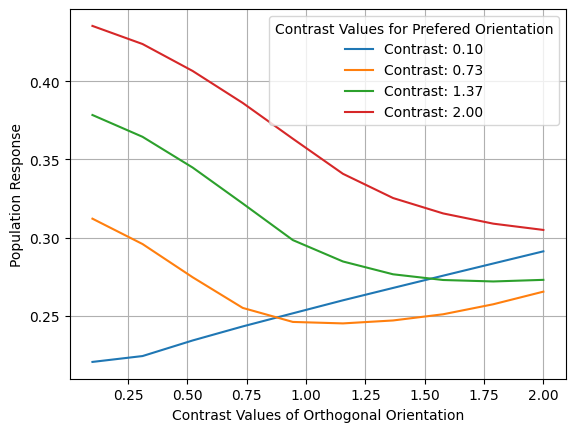

In [128]:
contrasts_orth = np.linspace(0.1, 2, 10)
contrasts_pref_sweep = np.linspace(0.1, 2, 4)
NUM_LAYERS = 5

for c in contrasts_pref_sweep:
    contrast_pref = np.linspace(c, c, 1)

    network_outputs_neurons = []
    for neuron in range(len(valid_neuron_indices)):
        pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[neuron]])

        gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size, center)

        network_layers = layers[0:NUM_LAYERS]
        network_outputs = network_layers(gratings)

        network_outputs_neurons.append(network_outputs[:, valid_neuron_indices[neuron_index],:,:].detach().numpy().mean(-1).mean(-1))

    stacked_vectors = np.vstack(network_outputs_neurons)

    _=plt.plot(contrasts_orth, np.mean(stacked_vectors, axis=0), label=f'Contrast: {c:.2f}')

plt.xlabel("Contrast Values of Orthogonal Orientation")
plt.ylabel("Population Response")

# Show the legend
plt.legend(title="Contrast Values for Prefered Orientation")
# Show the plot
plt.grid()
plt.show()

---

> **Assignment 8**
>
> Similarly to Assignment 7, how does the response to an optimal orientation change when we add an orthogonal grating?

Solution:

---


## 2. Rao and Ballard model of predictive coding in V1 <a class="anchor" id="rao_ballard"></a>


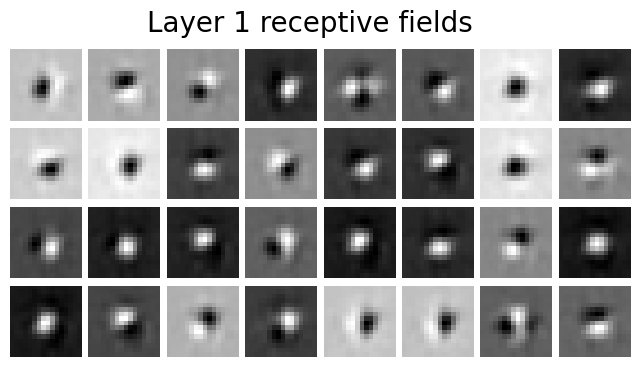

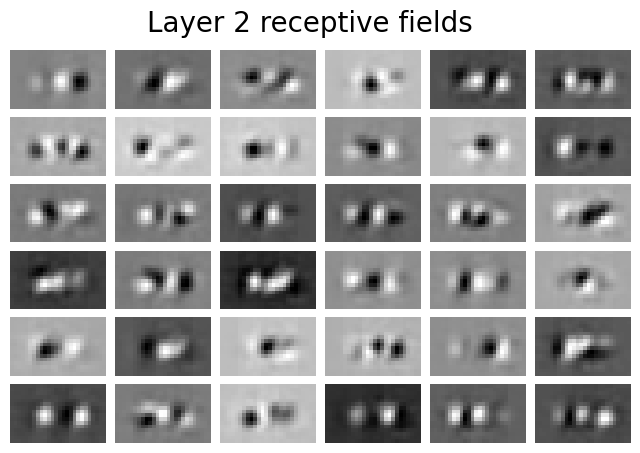

In [129]:
# Load the trained rao and ballard model
model = load_rao_ballard()

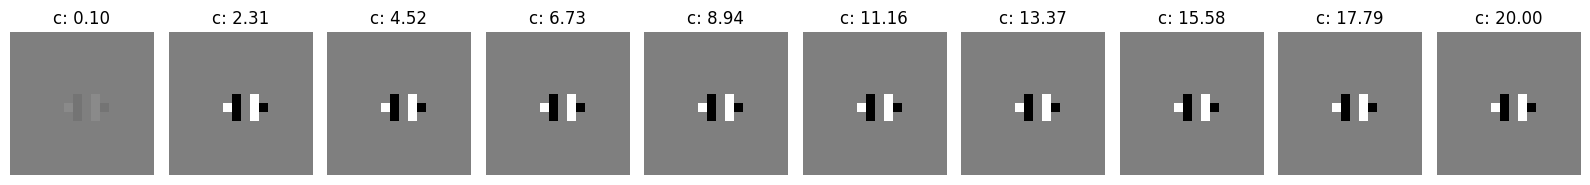

In [130]:
# Set parameters
frequency = 3
orientation = 90
radius = 2


# Generate different gratings with increasing contrasts
contrasts = np.linspace(0.1, 20, 10)
gratings = create_contrast_gratings(frequency, radius, contrasts, orientation, size=16, center=(8, 8))
plot_image_row(gratings, titles=[f'c: {c:.2f}' for c in contrasts])

In [131]:
model.initialize_states(gratings[0].reshape(3, 256).numpy())


layer_1_activities_per_contrast = np.zeros((len(gratings), 32))
layer_2_activities_per_contrast = np.zeros((len(gratings), 128))

for i, g in enumerate(gratings):
    # The model is expecting a flattened representation of the image
    er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
    layer_1_activities_per_contrast[i] = abs(l1).mean(0)
    layer_2_activities_per_contrast[i] = abs(l2)

## 2.1: Contrast saturation <a class="anchor" id="contrast_rao"></a>


Text(0, 0.5, 'Average activity')

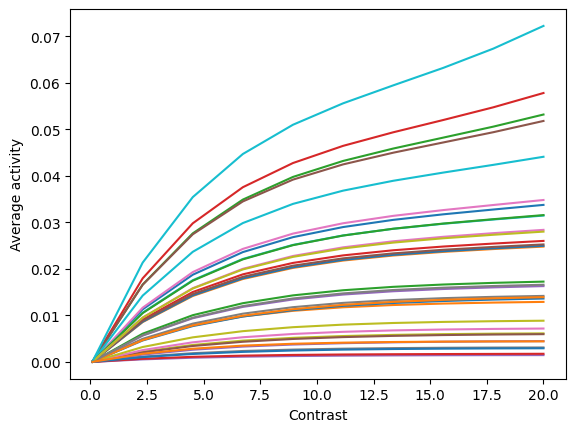

In [132]:
_=plt.plot(contrasts, layer_1_activities_per_contrast)
plt.xlabel("Contrast")
plt.ylabel("Average activity")

---

> **Assignment 10**
>
>Do neurons in layer 1 and layer 2 show contrast saturation?


Solution:

---


## 2.2: Cross-orientation inhibition <a class="anchor" id="inhibtion_rao"></a>


We will repeat this experiment similarly to the one in section (5) of Alexnet. First we determine for each neuron its preferred orientation. Then we select a neuron and we create a super-imposed grating consisting of its preferred grating and its orthogonal grating.



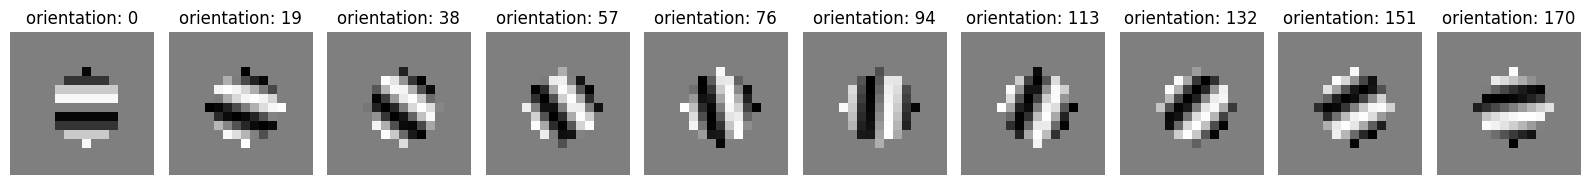

In [133]:
# Set parameters
frequency = 5
radius = 4
contrast = 2

orientations = np.linspace(0, 170, 10)

gratings = create_orientation_gratings(frequency, radius, contrast, orientations, size=16, center=(8, 8))
plot_image_row(gratings, titles=[f'orientation: {o:.0f}' for o in orientations])

In [134]:
model.initialize_states(gratings[0].reshape(3, 256).numpy())

layer_1_activities_per_orientation = np.zeros((len(gratings), 32))
layer_2_activities_per_orientation = np.zeros((len(gratings), 128))

for i, g in enumerate(gratings):
    # The model is expecting a flattened representation of the image
    er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
    layer_1_activities_per_orientation[i] = abs(l1).mean(0)
    layer_2_activities_per_orientation[i] = abs(l2)

Text(0, 0.5, 'Average activity')

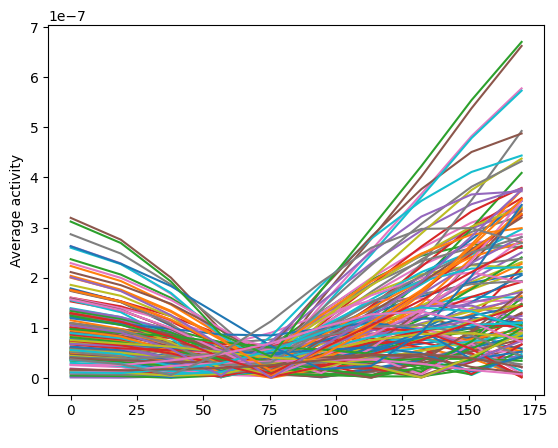

In [135]:
_=plt.plot(orientations, layer_2_activities_per_orientation)
plt.xlabel("Orientations")
plt.ylabel("Average activity")

In [136]:

m = layer_2_activities_per_orientation
print(m.shape) # Number of Stimuli Orientations x Number of Neurons
max_indices = np.argmax(m, axis=0) # We take the maximum across rows, i.e. for each neuron we look which stimuli elicited the highest response
neuron_pref_orientation = orientations[max_indices]
print(neuron_pref_orientation.shape)

(10, 128)
(128,)


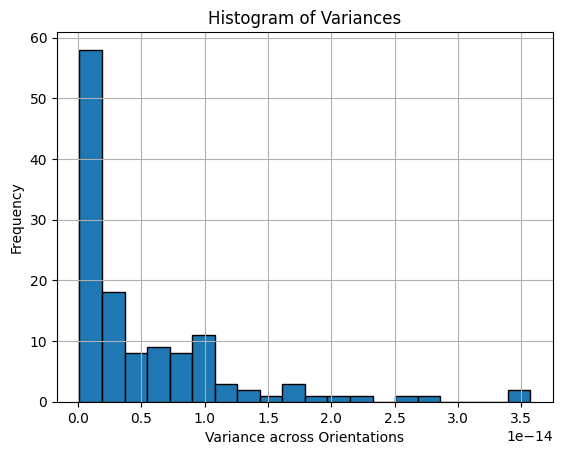

In [137]:
variances = np.var(m, axis=0)

# Plot the histogram of the variances
plt.hist(variances, bins=20, edgecolor='black')
plt.title("Histogram of Variances")
plt.xlabel("Variance across Orientations")
plt.ylabel("Frequency")
plt.grid()
plt.show()


In [138]:
valid_neurons = variances > 1e-14 # We select an *arbitrary* threshold to focus only on the most tuned units
valid_neuron_indices = np.nonzero(valid_neurons)[0]

print("A list of tuned units: ", valid_neuron_indices)

A list of tuned units:  [  4   5   6  16  22  23  24  27  33  58  69  71  75  79  87  88  96 114
 120 122 124 127]


Prefered orientation is 170 and orth orientation is 80


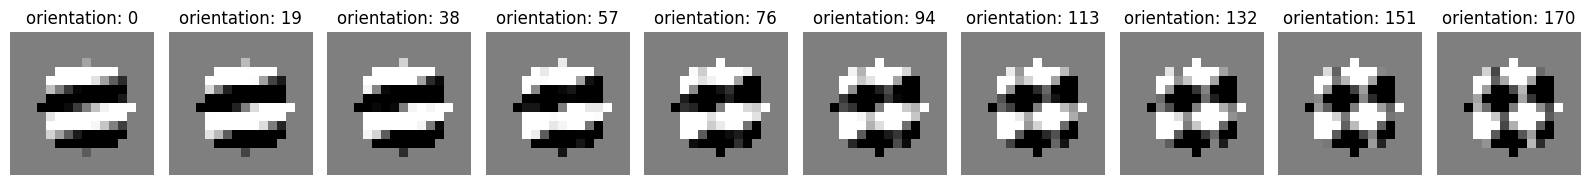

In [139]:
neuron_index = 0
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[neuron_index]])
print(f'Prefered orientation is {pref_orientation:.0f} and orth orientation is {orth_orientation:.0f}')

c = 2

frequency = 5
radius = 5

contrasts_orth = np.linspace(0.1, 2, 10)
contrast_pref = np.linspace(c, c, 1)
gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size=16, center=(8, 8))
plot_image_row(gratings, titles=[f'orientation: {o:.0f}' for o in orientations])



Prefered orientation is 170 and orth orientation is 80


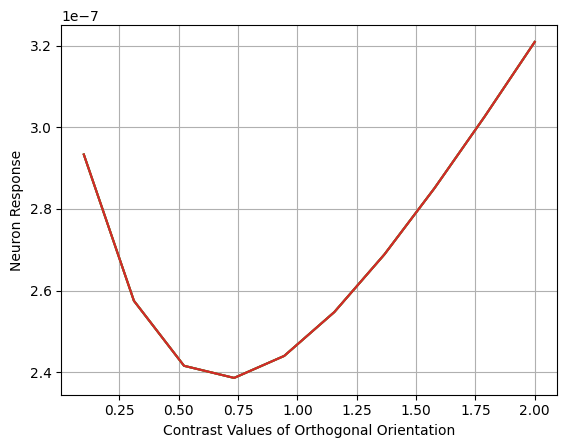

In [140]:
neuron_index = 0
pref_orientation, orth_orientation = get_pref_and_orth_angle(neuron_pref_orientation[valid_neuron_indices[neuron_index]])

print(f'Prefered orientation is {pref_orientation:.0f} and orth orientation is {orth_orientation:.0f}')

contrasts_orth = np.linspace(0.1, 2, 10)
contrasts_pref_sweep = np.linspace(2, 2, 4)

for c in contrasts_pref_sweep:
    contrast_pref = np.linspace(c, c, 1)
    gratings = create_superimposed_gratings(frequency, radius, contrast_pref, contrasts_orth, pref_orientation, orth_orientation, size=16, center=(8, 8))

    model.initialize_states(gratings[0].reshape(3, 256).numpy())


    layer_1_activities_per_orientation = np.zeros((len(gratings), 32))
    layer_2_activities_per_orientation = np.zeros((len(gratings), 128))

    for i, g in enumerate(gratings):
        # The model is expecting a flattened representation of the image
        er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
        layer_1_activities_per_orientation[i] = abs(l1).mean(0)
        layer_2_activities_per_orientation[i] = abs(l2)

    m = layer_2_activities_per_orientation[:, [valid_neuron_indices[neuron_index]]]

    _=plt.plot(contrasts_orth, m, label=f'Contrast: {c:.2f}')

plt.xlabel("Contrast Values of Orthogonal Orientation")
plt.ylabel("Neuron Response")

# Show the legend
#plt.legend(title='Contrast Values for Prefered Orientation')
# Show the plot
plt.grid()
plt.show()

---

>**Assignment 11**
>
> Do neurons in layer 1 show cross-orientation suppression?

Solution:


---

# 2.3: End-inhibition

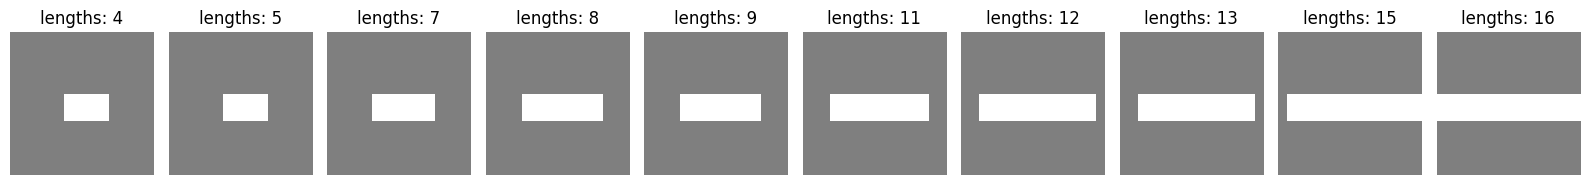

In [141]:
# Set parameters
size = 16
center = (8,8)
contrast = 2
width = 2

lengths = np.linspace(4, 16, 10)

bars = create_bar_lengths(size, contrast, center, lengths, width)
plot_image_row(bars, titles=[f'lengths: {l:.0f}' for l in lengths])

In [142]:
model.initialize_states(bars[0].reshape(3, 256).numpy())


layer_1_activities_per_contrast = np.zeros((len(bars), 32))
layer_2_activities_per_contrast = np.zeros((len(bars), 128))

for i, g in enumerate(bars):
    # The model is expecting a flattened representation of the image
    er1, er2, l1, l2 = model(g.reshape(3, 256).numpy())
    layer_1_activities_per_contrast[i] = abs(l1).mean(0)
    layer_2_activities_per_contrast[i] = abs(l2)

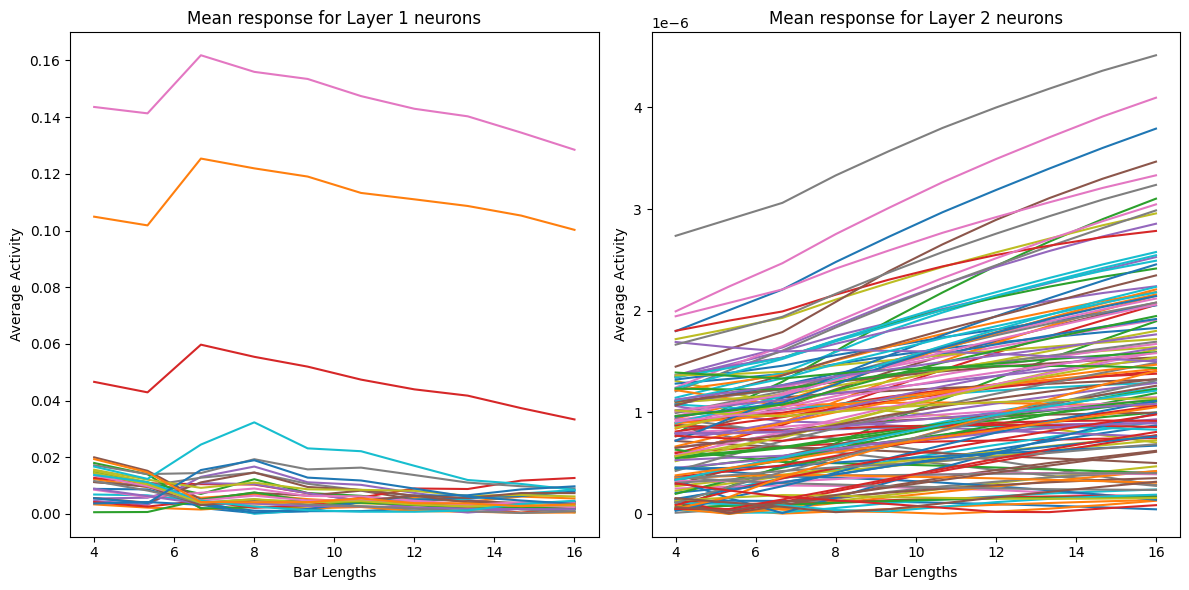

In [143]:
# Create a figure with two subplots side by side (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot for layer 1 neurons
ax1.plot(lengths, layer_1_activities_per_contrast)
ax1.set_xlabel("Bar Lengths")
ax1.set_ylabel("Average Activity")
ax1.set_title("Mean response for Layer 1 neurons")

# Plot for layer 2 neurons
ax2.plot(lengths, layer_2_activities_per_contrast)
ax2.set_xlabel("Bar Lengths")
ax2.set_ylabel("Average Activity")
ax2.set_title("Mean response for Layer 2 neurons")

# Display the plots side by side
plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()


---

> **Assignment 12**
>
> How does the response of a neuron change with stimulus size?

Solution:


---

# End of this exercise session
